# Assignment 4: a) Models fit to text data and b) Neural Networks
Machine Learning for the Social Sciences
Prof. Michael Parrot
10 December 2021
Yun Choi

## Part 1: Build a classification model using text data

In [3]:
# Import packages and functions to use
import aimodelshare as ai
import pandas as pd
import numpy as np
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import nltk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [4]:
# Import text data
X_train, X_test, y_train_labels, y_test_labels, example_data, lstm_model, lstm_model2 = ai.import_quickstart_data("clickbait")


Data downloaded successfully.

Preparing downloaded files for use...

Success! Your Quick Start materials have been downloaded. 
You are now ready to run the tutorial.


In [5]:
# Preprocess data
X_train_array=np.array(X_train)
X_test_array=np.array(X_test)
y_train_labels_encoded_array=np.array(pd.get_dummies(y_train_labels)['clickbait'])
y_test_labels_encoded_array=np.array(pd.get_dummies(y_test_labels)['clickbait'])

# Print first elements of X_train data
print(X_train_array)
# Print first elements of Y_train data
print(y_train_labels_encoded_array)

['MyBook Disk Drive Handles Lots of Easy Backups'
 'CIT Posts Eighth Loss in a Row'
 'Candy Carson Singing The "National Anthem" Is The Only Thing You Need Today'
 ... "38 Hilarious Vines We Couldn't Stop Watching In 2015"
 'Political Swing at Tennis Player Sours Dubai Tournament for All'
 'United States military death toll in Iraq reaches 4,000']
[0 0 1 ... 1 0 0]


In [6]:
# Check the balance between clickbaits and non-clickbaits
pd.get_dummies(y_train_labels)['clickbait'].value_counts()

0    12778
1    12201
Name: clickbait, dtype: int64

In [7]:
# Print the first elements of X_train data
print(X_train_array)
# Print the first elements of y_train data
print(y_train_labels_encoded_array)

['MyBook Disk Drive Handles Lots of Easy Backups'
 'CIT Posts Eighth Loss in a Row'
 'Candy Carson Singing The "National Anthem" Is The Only Thing You Need Today'
 ... "38 Hilarious Vines We Couldn't Stop Watching In 2015"
 'Political Swing at Tennis Player Sours Dubai Tournament for All'
 'United States military death toll in Iraq reaches 4,000']
[0 0 1 ... 1 0 0]


In [8]:
# Create a stopwords list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stopwords=list(ENGLISH_STOP_WORDS)

# Create LemmaTokenizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [9]:
# Create 3 tokenizers to compare
# vect1 - lowercased unigram without stopwords
vect1=CountVectorizer(lowercase=True, stop_words='english').fit(X_train_array)
# vect2 - lemmatizated and lowercased uni- and bi-grams without stopwords
vect2=CountVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words='english').fit(X_train_array)
# vect3 - lowercased uni- and bi-grams without stopwords
vect3=TfidfVectorizer(lowercase=True, norm=None, stop_words='english').fit(X_train_array)

/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


I tried three different vectorizers:
1. CountVectorizer(lowercase=True, stop_words='english')
2. CountVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words='english')
3. TfidfVectorizer(lowercase=True, norm=None, stop_words='english')

All three vectorizers lowercase words and exclude stopwords. But the second vectorizer is different from the first one in that it also lemmatizes words. The third vectorizer is different from the first two in that it penalizes common words. The others only count the number of times a word appears in the document without penalizing common words.

In [10]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


Vectorizer: CountVectorizer(stop_words='english')
  cross-validation score: 0.949
  test score: 0.953


None

Vectorizer: CountVectorizer(stop_words='english',
                tokenizer=<__main__.LemmaTokenizer object at 0x7f9aab871be0>)
  cross-validation score: 0.953
  test score: 0.960


None

Vectorizer: TfidfVectorizer(norm=None, stop_words='english')
  cross-validation score: 0.950
  test score: 0.954


None

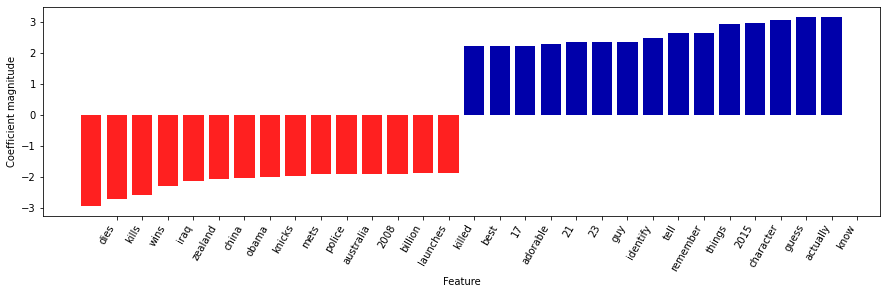

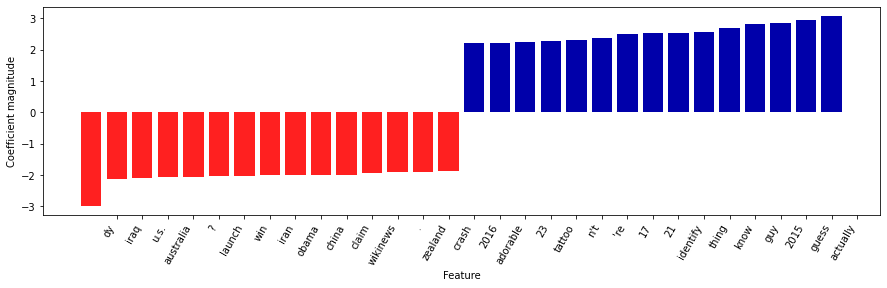

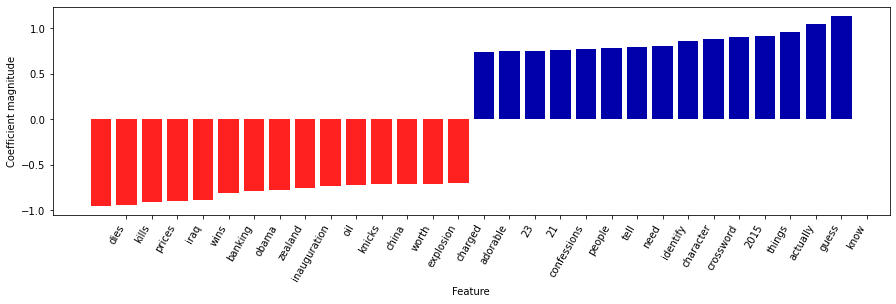

In [13]:
# Create a list of the vectorizers to feed into a for loop
vectorizers=[vect1, vect2, vect3]

for vect in vectorizers:
    X=vect.transform(X_train_array)
    X_test=vect.transform(X_test_array)
    scores=cross_val_score(LogisticRegression(), X, y_train_labels_encoded_array, scoring='f1')
    print("Vectorizer:", vect)
    print("  cross-validation score: {:.3f}".format(np.mean(scores)))
    # Get the predictions
    lr=LogisticRegression().fit(X, y_train_labels_encoded_array)
    y_pred = lr.predict(X_test)
    print("  test score: {:.3f}".format(f1_score(y_test_labels_encoded_array, y_pred)))
    coefs=lr.coef_
    feature_names=vect.get_feature_names()
    display(visualize_coefficients(coefs, feature_names, n_top_features=15))

The results above show the cross-validation and test scores, and 30 words most helpful determining a clickbait, for each vectorization approach.

**[Vectorizer #1]**
The first vectorizer, lowercasing all words and excluding stop words, produced the cross-validation score of 0.949, and the test score of 0.953.

The most important predictor words for a clickbait in a logistic regression model using the first vectorizer are 'actually', 'guess', and '2015', and the most important predictor words for a non-clickbait are 'dies', 'kills', and 'wins'.

The verbs remain singular because neither stemming or lemmatization has been applied.

**[Vectorizer #2]**
The second vectorizer, lemmatizing, lowercasing all words and excluding stop words, produced the cross-validation score of 0.953, and the test score of 0.960. Those are the highest among the results from the three vectorization approaches I tried.

The most important predictor words for a clickbait in a logistic regression model using the second vectorizer are same as those from the first one. But the most important predictor words for a non-clickbait are different, and they are 'dy', 'iraq', and 'u.s.' Thanks to lemmatization, the predictor 'dy' encompasses all forms of the verb 'die', and that includes 'dies', which is one of the most important predictor words from the first vectorization approach.

**[Vectorizer #3]**
The last vectorizer, lowercasing all words, excluding stop words, and penalizing common words, produced the cross-validation score of 0.95, and the test score of 0.954. Those are the second highest among the results from the three vectorization approaches.

The most important predictor words for a clickbait in a logistic regression model using the third vectorizer are 'know', 'guess', and 'actually'. The most important predictor words for a non-clickbait are 'dies', 'kills', and 'prices'. When comparing to the results from the first vectorization approach, I can notice that the word 'wins' has been dropped. That implies that the word 'wins' may be too common across the document to be one of the greatest predictors for a non-clickbait.

I would ultimately choose the second vectorizer not only because it produces the highest cross-validation and test scores, but also it seems most theoretically sound. Lemmatization groups together many forms of a word so they can be analyzed as a single item as they should.

## Part 2: Build a predictive neural network using Keras

In [42]:
# Import packages
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [23]:
# fix random seed for reproducibility
np.random.seed(42)

In [24]:
# Import data
df=pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv", index_col=0)
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [25]:
print("Unique Species: ", df['Species'].unique())

Unique Species:  ['setosa' 'versicolor' 'virginica']


In [26]:
# Recode dependent variable
df.loc[df["Species"]=="setosa","Species"]=0
df.loc[df["Species"]=="versicolor","Species"]=1
df.loc[df["Species"]=="virginica","Species"]=2

In [27]:
# Create X and y data
y = df['Species']
X = df.loc[:, df.columns != 'Species']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# Standardize data with StandardScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
# Create a model
def create_model(hiddennodes=200):
    # create model
    model=Sequential()
    model.add(Dense(hiddennodes, input_dim=4, activation='relu'))
    model.add(Dense(hiddennodes, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    sgd = SGD(learning_rate=0.001)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Building a simple search grid that adjusts epochs
param_grid = dict(hiddennodes=[200, 250, 300, 350, 400])
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_scaled, y_train)
print(" Tuning Parameters: {}".format(grid.best_params_))
print("   best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("   test-set score: {:.3f}".format(grid.score(X_test_scaled, y_test)))

/var/folders/h9/0f45b_ds7dl174n175hjm_sm0000gn/T/ipykernel_31931/1264335439.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model)


4/4 [==============================] - 1s 4ms/step - loss: 1.0316 - accuracy: 0.5893
 Tuning Parameters: {'hiddennodes': 200}
   best mean cross-validation score: 0.526
2/2 [==============================] - 0s 12ms/step - loss: 1.0283 - accuracy: 0.6053
   test-set score: 0.605


The result above shows that among the five values I tried for the number of hidden nodes in each layer - 200, 250, 300, 350, and 400 - the value of 200 produces the best mean cross-validation score of 0.526. The test score of 0.605, which is higher than the mean cross-validation score, implies a low risk of overfitting.

I took a closer look at:

In [46]:
X_train_scaled_nparray=np.asarray(X_train_scaled).astype(np.int64)
X_test_scaled_nparray=np.asarray(X_test_scaled).astype(np.int64)
y_train=np.asarray(y_train).astype(np.int)
y_test=np.asarray(y_test).astype(np.int)

model1=Sequential()
model1.add(Dense(200, input_dim=4, activation='relu'))
model1.add(Dense(200, activation='relu'))
model1.add(Dense(3, activation='softmax'))
sgd = SGD(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model1.fit(X_train_scaled, y_train)
    #core = model.evaluate(X_test_scaled, y_test)
    #print("Number of nodes in each hidden layer:", i)
    #print("   test-set score: {:.3f}", score)

/var/folders/h9/0f45b_ds7dl174n175hjm_sm0000gn/T/ipykernel_31931/2245650403.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train=np.asarray(y_train).astype(np.int)
/var/folders/h9/0f45b_ds7dl174n175hjm_sm0000gn/T/ipykernel_31931/2245650403.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

ValueError: in user code:

    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/yunchoi/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
